In [1]:
import time
from typing import Optional, Tuple, List


import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.__version__

'1.13.1+cu117'

In [4]:
from torchvision import datasets
from torchvision.transforms import ToTensor

train_data = datasets.MNIST(
    root='../models/mnist',
    train=True,
    transform=ToTensor(),
    download=True,
)

test_data = datasets.MNIST(
    root='../models/mnist',
    train=False,
    transform=ToTensor(),
    download=True,
)

In [5]:
class TrainHelper:
    @staticmethod
    def train(cnn: nn.Module,
              *,
              lr: float,
              epochs: int,
              train_dataset: datasets.MNIST,
              test_dataset: Optional[datasets.MNIST] = None,
              print_results: bool = True,
              batch_size: int,
              device_name: str) -> List[float]:

        train_loader = torch.utils.data.DataLoader(train_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=1)

        device = torch.device(device_name)

        cnn.to(device)
        cnn.train()

        optimizer = torch.optim.Adam(cnn.parameters(), lr=lr)
        loss_func = nn.CrossEntropyLoss()

        eval_results: List[float] = []

        for epoch in range(epochs):
            for images, labels in train_loader:
                images = Variable(images.to(device))
                labels = Variable(labels.to(device))

                output = cnn(images)
                loss = loss_func(output, labels)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            if test_dataset is not None:
                eval_result = TrainHelper.test(cnn, test_dataset, device)
                eval_results.append(eval_result)
                if print_results:
                    print(f"epoch {epoch}, accuracy = {eval_result}, loss = {loss.detach()}")
                cnn.train()

        return eval_results

    @staticmethod
    def test(cnn: nn.Module, test_dataset: datasets.MNIST, device=None) -> float:
        cnn.eval()
        loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=1)
        correct = 0
        incorrect = 0

        for images, labels in loader:
            if device is not None:
                images = images.to(device)

            results = cnn(images)
            predictions = results.detach().cpu().numpy().argmax(axis=1)
            oks = (predictions == labels.numpy()).sum()
            correct += oks
            incorrect += len(predictions) - oks

        return correct / (correct + incorrect)

    @staticmethod
    def train_models(models: List[nn.Module], device_name: str, batch_size: int, lr: float) -> Tuple[int, float]:
        """
        generator yields pair (trainable parameters count, best accuracy) for each network
        :param device_name: 'cuda' or 'cpu'
        """
        assert len(models) > 0

        for model in models:
            start = time.time()
            eval_results = TrainHelper.train(
                lr=lr,
                cnn=model,
                epochs=20,
                train_dataset=train_data,
                test_dataset=test_data,
                batch_size=batch_size,
                device_name=device_name,
                print_results=False
            )
            end = time.time()
            best_acc = max(eval_results)
            params_count = TrainHelper.total_parameters_count(model)
            print(f"best accuracy = {best_acc}, parameters = {params_count}, training time = {end - start}")
            yield params_count, best_acc

    @staticmethod
    def total_parameters_count(model: nn.Module) -> int:
        return sum(np.prod(p.size()) for p in model.parameters())

    @staticmethod
    def print_parameters(model: nn.Module):
        print(f"total parameters = {TrainHelper.total_parameters_count(model)}")
        for p in model.parameters():
            print(f"size {np.prod(p.size())}: {p.size()}")

In [6]:
class MyTransformer(nn.Module):
    def __init__(self, ch: int, kq_ch: int, img_size: int, ff_ch: int):
        super(MyTransformer, self).__init__()

        self.attention = MyAttention3x3(in_ch=ch, kq_ch=kq_ch, out_ch=ch, img_size=img_size)

        self.norm1 = nn.BatchNorm2d(ch)
        self.norm2 = nn.BatchNorm2d(ch)

        self.ff = nn.Sequential(
            nn.Conv2d(ch, ff_ch, kernel_size=1, bias=True),
            nn.LeakyReLU(0.1),
            nn.Conv2d(ff_ch, ch, kernel_size=1, bias=True),
        )

    def forward(self, x):
        x = self.norm1(self.attention(x) + x[:, :, 1:-1, 1:-1])
        x = self.norm2(self.ff(x) + x)
        return x

In [7]:
class MyAttention3x3(nn.Module):
    def __init__(self, in_ch: int, kq_ch: int, out_ch: int, img_size: int):
        super(MyAttention3x3, self).__init__()

        self.in_ch: int = in_ch
        self.out_ch: int = out_ch
        self.img_size: int = img_size

        # size = [b_s, ch, h, w]
        self.to_key = nn.Conv2d(in_ch, kq_ch, kernel_size=1, bias=False)
        self.to_query = nn.Conv2d(in_ch, kq_ch, kernel_size=1, bias=False)
        self.to_value = nn.Conv2d(in_ch, out_ch, kernel_size=1, bias=False)

        self.key_pos_embedding = nn.Parameter(torch.zeros(size=(1, 1, kq_ch)))
        self.query_pos_embedding = nn.Parameter(torch.zeros(size=(1, 9, kq_ch)))
        self.value_pos_embedding = nn.Parameter(torch.zeros(size=(1, 9, out_ch)))

    def repack_img(self, img: torch.Tensor):
        batch_size, channels, height, width = img.size()
        assert width == self.img_size
        assert height == self.img_size

        img = img.view(batch_size, channels, height, width, 1)

        new_w = width - 2
        new_h = height - 2

        img = torch.cat([img[:, :, :, i: new_w + i] for i in range(3)], dim=4)
        img = torch.cat([img[:, :, i: new_h + i] for i in range(3)], dim=4)
        assert img.size() == (batch_size, channels, new_h, new_w, 9)

        img = torch.moveaxis(img, 1, 4)
        assert img.size() == (batch_size, new_h, new_w, 9, channels)

        img = img.reshape(batch_size * new_h * new_w, 9, channels)
        return img

    def forward(self, x):
        batch_size, channels, height, width = x.size()

        key = self.to_key(x)
        query = self.to_query(x)
        value = self.to_value(x)

        packed_key = self.repack_img(key)[:, 4:5] + self.key_pos_embedding
        # b, 1, ch
        packed_query = self.repack_img(query) + self.query_pos_embedding
        # b, 9, ch
        packed_value = self.repack_img(value) + self.value_pos_embedding
        # b, 9, out_ch

        dots = torch.bmm(packed_key, torch.moveaxis(packed_query, 1, 2))
        assert dots.size() == (batch_size * (height - 2) * (width - 2), 1, 9)

        weights = F.softmax(dots / 3.0, dim=2)
        # b, 1, 9

        out = torch.bmm(weights, packed_value)
        assert out.size() == (batch_size * (height - 2) * (width - 2), 1, self.out_ch)
        # b, 1, ch

        out = out.reshape(batch_size, height - 2, width - 2, self.out_ch)
        out = torch.moveaxis(out, 3, 1)

        return out


In [8]:
class MyConvT3(nn.Module):
    def __init__(self, channels: int):
        super(MyConvT3, self).__init__()

        c = channels
        self.layers = nn.Sequential(
            nn.Conv2d(1, c, kernel_size=1, padding="valid", bias=False),  # 28
            MyTransformer(c, c, 28, c * 2),  # 26
            MyTransformer(c, c, 26, c * 2),  # 24
            nn.MaxPool2d(2),  # 12

            nn.Conv2d(c, c * 2, kernel_size=1, padding="valid", bias=False),  # 12
            MyTransformer(c * 2, c * 2, 12, c * 4),  # 10
            MyTransformer(c * 2, c * 2, 10, c * 4),  # 8
            nn.MaxPool2d(2),  # 4

            MyTransformer(c * 2, c * 4, 4, c * 8),  # 2
            nn.Conv2d(c * 2, c * 4, kernel_size=2, padding="valid", bias=False),  # 1
            nn.BatchNorm2d(c * 4),
            nn.LeakyReLU(0.1),

            nn.Conv2d(c * 4, 10, kernel_size=1),  # 1
            nn.Flatten(),
        )

    def conv(self, in_ch: int, out_ch: int, *, kernel_size):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size, padding='valid', bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.1),
        )

    def forward(self, x: torch.Tensor):
        return self.layers(x)

In [9]:
results = []

In [10]:
device_name = 'cuda' if torch.cuda.is_available() else 'cpu'

for i in range(4):
    models = [MyConvT3(n) for n in reversed([4, 6, 8, 12, 16, 24, 32, 48, 64])]
    for pair in TrainHelper.train_models(models, device_name=device_name, batch_size=256, lr=0.0003):
        results.append(pair)

best accuracy = 0.9888, parameters = 656970, training time = 1624.5554239749908
best accuracy = 0.9882, parameters = 372922, training time = 1224.6352667808533
best accuracy = 0.9878, parameters = 168746, training time = 791.2550809383392
best accuracy = 0.9871, parameters = 96610, training time = 602.2606484889984
best accuracy = 0.9849, parameters = 44442, training time = 417.74336218833923
best accuracy = 0.9806, parameters = 25846, training time = 328.79275131225586
best accuracy = 0.9788, parameters = 12242, training time = 240.84047985076904
best accuracy = 0.9726, parameters = 7312, training time = 214.0488588809967
best accuracy = 0.9506, parameters = 3630, training time = 202.0142846107483
best accuracy = 0.975, parameters = 656970, training time = 1561.9381036758423
best accuracy = 0.9876, parameters = 372922, training time = 1215.6311104297638
best accuracy = 0.9885, parameters = 168746, training time = 792.5143005847931
best accuracy = 0.9859, parameters = 96610, training t

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


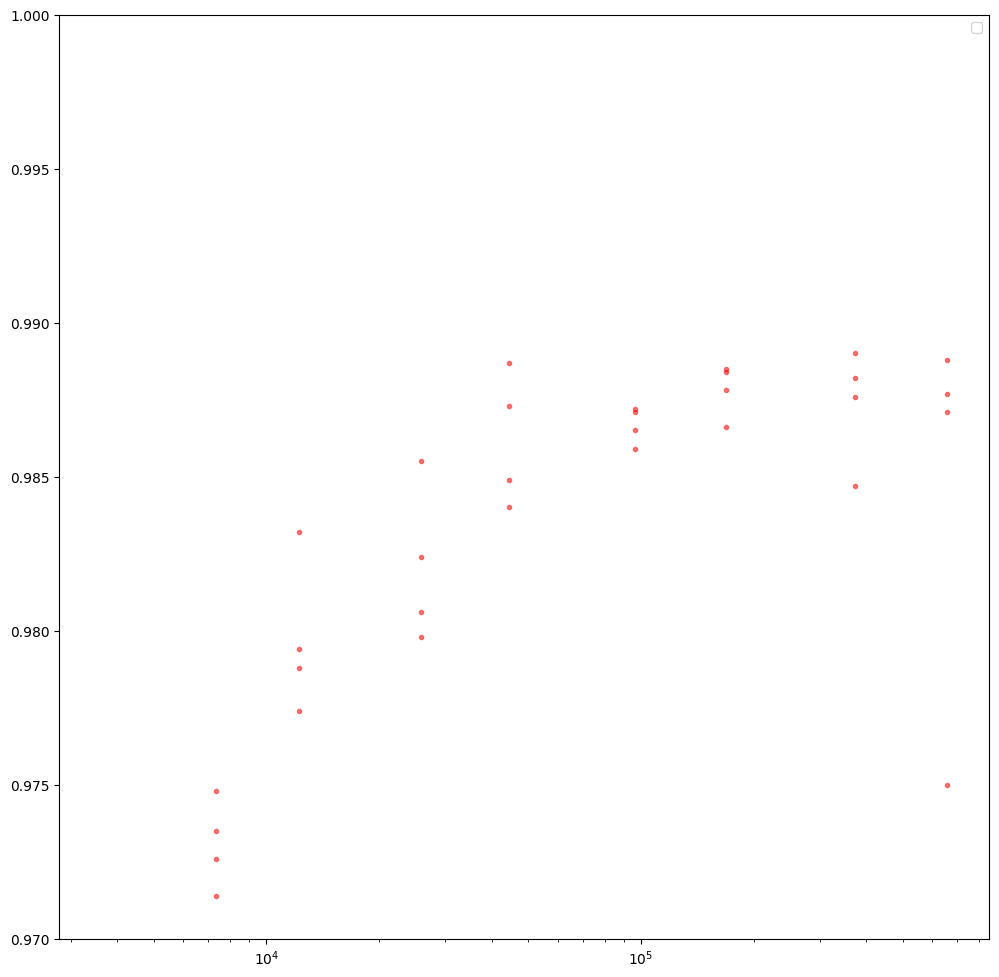

In [11]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_ylim(0.97, 1)

params_counts = [p[0] for p in results]
accuracies = [p[1] for p in results]

ax.scatter(params_counts, accuracies, c='red', alpha=0.5, marker=r'.')

ax.legend()
plt.show()